# CNTK_206B: Time series prediction with LSTM

In  [part A of this tuturial](CNTK_206A_IOT_Example_with_LSTM.ipynb) we developed a simple LSTM network to predict future values in a time series.
In part B we want to use the model on some real world IOT data. As example we want to predict the daily output of a solar panel base on the initial readings of a the day. We train the model with historical data of the solar panel. 

For more details on how LSTMs work, see [this excellent posts](http://colah.github.io/posts/2015-08-Understanding-LSTMs).

In our example we want to have our model do the following:

Starting with the initial readings of the day, we want to predict the total power production of the solar panel array for the day. We start predicting after the first 2 readings and adjust the prediction with each new reading.
Our training data format looks like this:
```
time,solar.current,solar.total
7am,6.3,1.7
7:30am,44.3,11.4
...

solar.current is the current production in Watt
solar.total is the total produced for the day so far in Watt/hour
1 reading is taken every 30 minutes
```

The training dataset with data captured for 3 years is [here](https://guschmueds.blob.core.windows.net/datasets/solar.csv). 
We intentionally did not cleanup the dataset and it contains smaller gabs and errors (like a panel failed to report datapoints) which we want the model to tolerate.

The model has the following design:
![lstm](https://guschmueds.blob.core.windows.net/datasets/2.png)

We use a 14 cell LSTM, 1 cell for each datapoint we take during the day.
With a reading taken every 30 minutes we get around 14 datapoints a day. We truncate if we receive more than 14 readings.
14 sequences of 14 values are feed to the neural net as input. Values we don't know are set to 0. 
The output of the neural network is the total output for the day and each sequence for a given day has the same total output.
For example:
```
1.7,11.4,0,0,0,0,0,0, ... -> 10300
1.7,11.4,67.5,0,0,0,0,0,0,0, ... -> 10300
1.7,11.4,67.5,250.5,0,0,0,0,0,0, ... -> 10300
1.7,11.4,67.5,250.5,573.5,0,0,0,0,0,0, ... -> 10300
```

The outputs from the LSTMs are feed into a dense layer and we randomly dropout 20% of the values to not overfit the model to the training set. The output of the dense layer becomes the prediction our model generates.

You might have noticed that we lost the timestamp for the datapoint; in our model only the sequences of readings matters. 

Lets get started with some imports and some constants.

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time
import math
import random

import cntk
import cntk.layers
import cntk.models

# there are 14 lstm cells, 1 for each reading we get per day
TIMESTEPS = 14
# 20000 is the maximum output. we normalize all values with 
# this so our inputs are between 0.0 and 1.0. 
SCALER = 20000 
# process batches of 10 days
BATCH_SIZE = TIMESTEPS * 10
# we need around 500 epochs to see decent results. But for testing
# use 100 to speed things up.
EPOCHS = 2000

The most of the code in this example is related to data preperation. Luckily the pandas library make this easy.

generate_solar_data() reads solar.csv as pandas dataframe, normalizes the data and appends the columns "solar.current.max" and "solar.total.max" to each row.
Than it generates the 14 value sequences decribed earlier.

split_data() splits the full dataset into training, valiadation and test sets.

next_batch() is an iterator() that yields the next batch for training. Note that CNTK allows for variable size sequences so batches must be passed as list of sequences. A standard practice is to shuffle batches with each epoch. We don't do here because we want to be able to graph the data easily.

In [3]:
def split_data(data, val_size=0.1, test_size=0.1):
    """
    splits data into training, validation and test
    """
    pos_test = int(len(data) * (1 - test_size))
    pos_val = int(len(data[:pos_test]) * (1 - val_size))

    train, val, test = data[:pos_val], data[pos_val:pos_test], data[pos_test:]

    return {"train": train, "val": val, "test": test}


def generate_solar_data(input_file, time_steps, normalize=1, shuffle=False):
    """
    generate sequences to feed to rnn based on data frame with solar panel data
    the csv has has the format: time,solar.current,solar.total
     (solar.current is the current output in Watt, solar.total is the total production
      for the day so far in Watt hours)
    """
    df = pd.read_csv(input_file, index_col="time", parse_dates=['time'])
    df["date"] = df.index.date
    # normalize data to 0.0-1.0
    df['solar.current'] /= normalize
    df['solar.total'] /= normalize
    # group by day, find the max for a day and add a new column .max
    grouped = df.groupby(df.index.date).max()
    grouped.columns = ["solar.current.max", "solar.total.max", "date"]
    # merge continoues readings and daily max values into 1 frame
    df3 = pd.merge(df, grouped, right_index=True, on="date")
    df3 = df3[["solar.current", "solar.total", "solar.current.max", "solar.total.max"]]
    # we group by day so we can process a day at a time. If desired random shuffle days
    grouped = df3.groupby(df3.index.date)
    per_day = []
    for _, group in grouped:
        per_day.append(group)
    if shuffle:
        random.shuffle(per_day)

    # generate sequences of time_steps for each day
    rnn_x = []
    rnn_y = []
    for d in per_day:
        total = d["solar.total"].values
        if len(total) > 1:
            # we need at least values 
            for i in range(2, len(total)):
                val = [0] * time_steps
                val[0:i] = total[0:i]
                rnn_x.append(np.array(val))
                rnn_y.append(np.array(d["solar.total.max"].values[0]))
                if i >= time_steps:
                    break
    rnn_x = np.array(rnn_x)
    rnn_x = rnn_x.reshape(rnn_x.shape + (1,))
    rnn_y = np.array(rnn_y)
    rnn_y = rnn_y.reshape(rnn_y.shape + (1,))
    return split_data(rnn_x), split_data(rnn_y)

    
def next_batch(x, y, ds):

    def as_batch(data, start, count):
        part = []
        for i in range(start, start + count):
            part.append(data[i])
        return np.array(part)

    for i in range(0, len(x[ds])-BATCH_SIZE, BATCH_SIZE):
        yield as_batch(X[ds], i, BATCH_SIZE), as_batch(Y[ds], i, BATCH_SIZE)
        

X, Y = generate_solar_data("https://guschmueds.blob.core.windows.net/datasets/solar.csv", TIMESTEPS, normalize=SCALER, shuffle=False)
print("data loaded: x={}, y={}".format(X['train'].shape, Y['train'].shape))

data loaded: x=(10925, 14, 1), y=(10925, 1)


You can now see the sequence we are going to feed to the LSTM. 
The sequences are back to back and there is no longer a notion of time in it, for example:

In [4]:
X['train'][0:2]

array([[[  8.45000029e-05],
        [  5.67999995e-04],
        [  0.00000000e+00],
        [  0.00000000e+00],
        [  0.00000000e+00],
        [  0.00000000e+00],
        [  0.00000000e+00],
        [  0.00000000e+00],
        [  0.00000000e+00],
        [  0.00000000e+00],
        [  0.00000000e+00],
        [  0.00000000e+00],
        [  0.00000000e+00],
        [  0.00000000e+00]],

       [[  8.45000029e-05],
        [  5.67999995e-04],
        [  3.37500000e-03],
        [  0.00000000e+00],
        [  0.00000000e+00],
        [  0.00000000e+00],
        [  0.00000000e+00],
        [  0.00000000e+00],
        [  0.00000000e+00],
        [  0.00000000e+00],
        [  0.00000000e+00],
        [  0.00000000e+00],
        [  0.00000000e+00],
        [  0.00000000e+00]]])

Defining the model in CNTK is easy - we create a LSTM with TIMESTEPS cells and feed their output into a dense layer that has a single output:

In [5]:
def lstm_model(x):
    with cntk.layers.default_options(initial_state=0.1):
        m = cntk.layers.Recurrence(cntk.layers.LSTM(TIMESTEPS))(x)
        m = cntk.ops.sequence.last(m)
        m = cntk.layers.Dropout(0.2)(m)
        m = cntk.layers.Dense(1)(m)
        return m

Before we can start training we need to bind our input variables for the model and define the opimizer. 
For this example we choose the adam optimizer.

In [6]:
x_axes = [cntk.Axis.default_batch_axis(), cntk.Axis.default_dynamic_axis()]
y_axes = [cntk.Axis.default_batch_axis()]

x = cntk.input_variable((1), np.float32, dynamic_axes=x_axes, name="x")
y = cntk.input_variable((1), np.float32, dynamic_axes=y_axes, name="y")
z = lstm_model(x)

learning_rate = 0.01
lr_schedule = cntk.learning_rate_schedule(learning_rate, cntk.UnitType.minibatch)

loss = cntk.ops.squared_error(z, y)
error = cntk.ops.squared_error(z, y)

momentum_time_constant = cntk.learner.momentum_as_time_constant_schedule(BATCH_SIZE / -math.log(0.9)) 
learner = cntk.learner.adam_sgd(z.parameters, lr=lr_schedule, momentum=momentum_time_constant)
trainer = cntk.Trainer(z, loss, error, [learner])

Time to start trainnig. For EPOCHS=2000 this will take a couple of minutes. Because we have few datapoints (14*3*365) we need many of epochs of training. 

In [7]:
# training
loss_summary = []
start = time.time()
for epoch in range(0, EPOCHS):
    for _x, _y in next_batch(X, Y, "train"):
        trainer.train_minibatch({x: _x, y: _y})
        
    if epoch % (EPOCHS / 10) == 0:
        training_loss = cntk.utils.get_train_loss(trainer)
        loss_summary.append(training_loss)
        print("epoch: {}, loss: {:.4f}".format(epoch, training_loss))

print("training took {} sec".format(time.time() - start))

epoch: 0, loss: 0.0992
epoch: 200, loss: 0.0084
epoch: 400, loss: 0.0043
epoch: 600, loss: 0.0034
epoch: 800, loss: 0.0028
epoch: 1000, loss: 0.0031
epoch: 1200, loss: 0.0030
epoch: 1400, loss: 0.0029
epoch: 1600, loss: 0.0026
epoch: 1800, loss: 0.0031
training took 847.1341071128845 sec


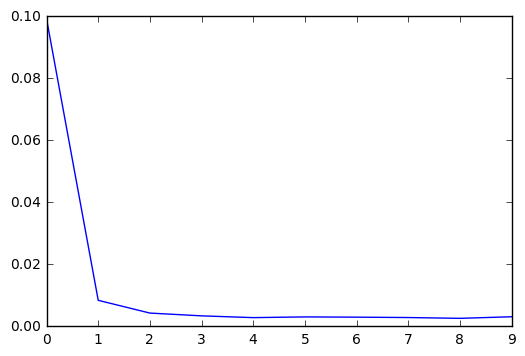

In [8]:
# A look how the loss function shows how fast the model is converging
plt.plot(loss_summary, label='training loss');

Lets validate the training. Since the dataset is small we can validate train, validation and test dataset.

In [9]:
# validate
for ds in ["train", "val", "test"]:
    result = 0.0
    for x_, y_ in next_batch(X, Y, ds):
        eval_error = trainer.test_minibatch({x: x_, y:y_})
        result += eval_error
    print("msre for {}: {:.8f}".format(ds, result / len(X[ds])))

msre for train: 0.00002421
msre for val: 0.00000534
msre for test: 0.00002422


This looks good. The nice thing with time series data is that we can visualize the results easily.

Lets take our newly created model, make predictions and plot them against the actual readings.

There are errors here and there but considering the simplicity of the model and the nature of the data its suprising how well this works. 
We can zoom in and look at individual days:

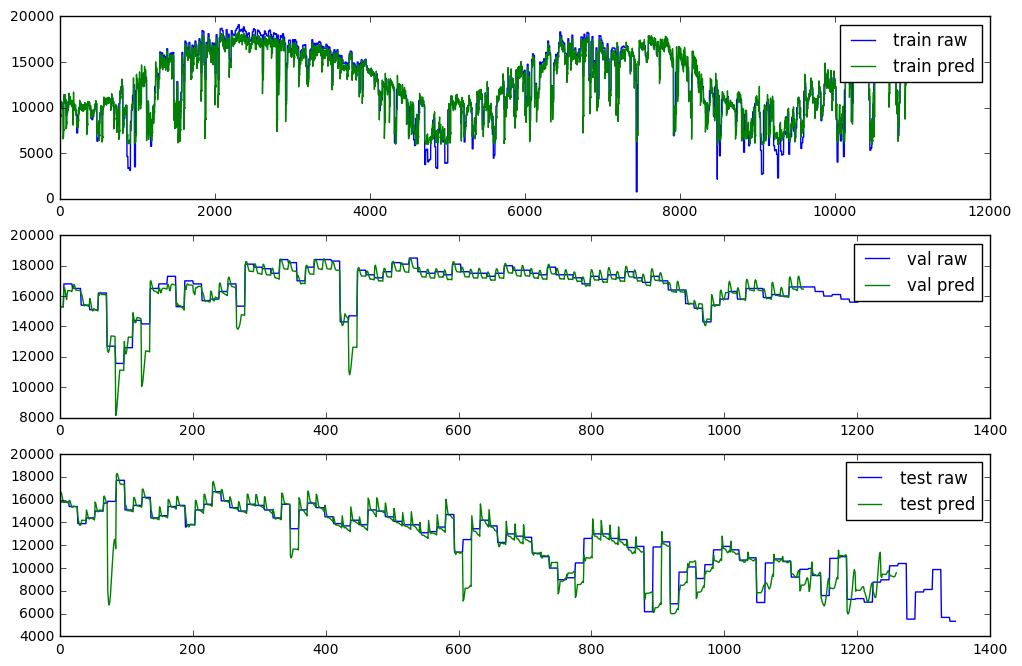

In [10]:
# predict
f, a = plt.subplots(3, 1, figsize=(12, 8))
for j, ds in enumerate(["train", "val", "test"]):
    results = []
    for x_, _ in next_batch(X, Y, ds):
        pred = z.eval({x: x_})
        results.extend(pred[:, 0])
    # because we normalized the input data we need to multiply the prediction
    # with SCALER to get the real values.
    a[j].plot(Y[ds] * SCALER, label=ds + ' raw');
    a[j].plot(np.array(results) * SCALER, label=ds + ' pred');
    a[j].legend();

The predictions are close to the actual data and definitly follow the right pattern. 
We can zoom in a little to see individual days:

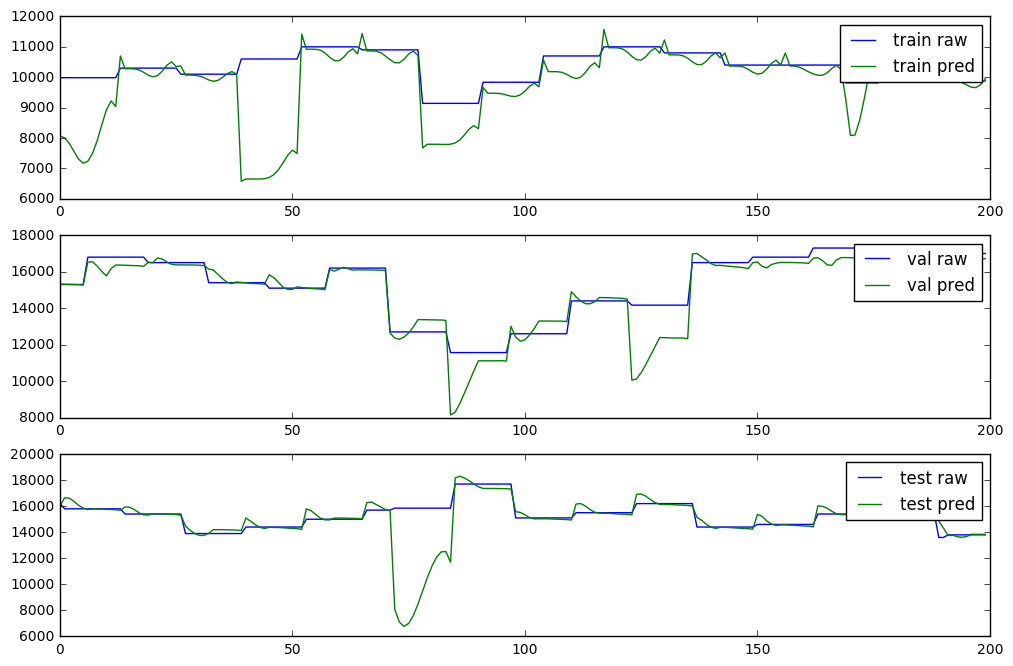

In [11]:
f, a = plt.subplots(3, 1, figsize=(12, 8))
for j, ds in enumerate(["train", "val", "test"]):
    results = []
    for x_, y_ in next_batch(X, Y, ds):
        pred = z.eval({x: x_})
        results.extend(pred[:, 0, 0])
    zoom = 200
    a[j].plot(Y[ds][:zoom] * SCALER, label=ds + ' raw');
    a[j].plot(np.array(results)[:zoom] * SCALER, label=ds + ' pred');
    a[j].legend();

While the results are ok for a tutorial, they are most likely not good enough for real applications.
But one can improve on this. A few things to try: 
- let the model train for more epochs. As long the loss is going down this should help
- cleanup the input data, like remove days with partial data
- increase the resolution of the input data, for example read datapoints every 5 minutes instead of every 30 minutes.
- switch the model to use variable length sequences instead of padding with 0
- add more inputs: we can train the LSTM on more than one sequence per output. For the solar panel data we could have one sequence with the current reading and one with the current total and train the model with both sequences against the output.
- change the model, for example add another layer of LSTMs on top of the first layer

We hope that gets you started on time series prediction with real world data.